In [1]:
!pip install aeon
!pip install scikeras

In [1]:
from aeon.datasets import load_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import random
import torch
import torch.nn as nn

2024-03-20 13:28:53.812373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 13:28:55.988066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. FaultDetectionA

In [89]:
X, y, metadata = load_classification(name="FaultDetectionA",return_metadata=True)
# y = np.array([int(i)-1 for i in y])
y = to_categorical(y) # we need to feed the model with ohe labels for tf.keras categorical_crossentropy loss
X.shape , y.shape

((13640, 1, 5120), (13640, 3))

In [90]:
type(X[0][0][0]), type(y[0][0])

(numpy.float64, numpy.float64)

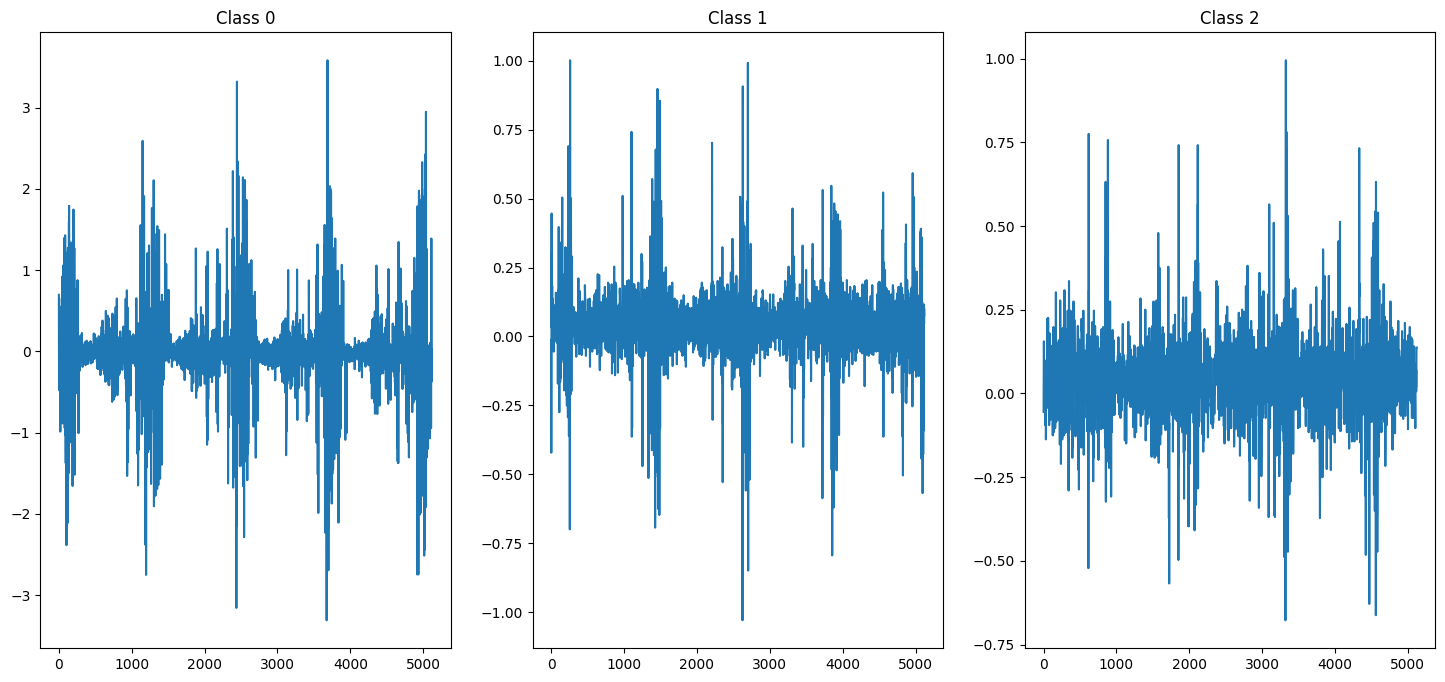

In [123]:
# print examples of the 3 classes, labels are one-hot encoded and time series in 5120 timesteps
time = np.arange(0, 5120)
class_0 = np.where(y[:, 0] == 1)[0]
class_1 = np.where(y[:, 1] == 1)[0]
class_2 = np.where(y[:, 2] == 1)[0]

plt.subplots(1, 3, figsize=(18, 8))
plt.subplot(1, 3, 1)
plt.plot(time, X[random.choice(class_0)].reshape(-1))
plt.title('Class 0')
plt.subplot(1, 3, 2)
plt.plot(time, X[random.choice(class_1)].reshape(-1))
plt.title('Class 1')
plt.subplot(1, 3, 3)
plt.plot(time, X[random.choice(class_2)].reshape(-1))
plt.title('Class 2')
plt.show()

In [91]:
# def load_dataset(PATH):
#   loaded_data = np.load(PATH)
#   X_train = loaded_data['X_train']
#   X_test = loaded_data['X_test']
#   y_train = loaded_data['y_train']
#   y_test = loaded_data['y_test']
#   indices = loaded_data['indices']
#   X_train_deq = X_train[indices]
#   y_train_deq = y_train[indices]

#   return X_train, X_test, X_train_deq, y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0]), y_train_deq.reshape(y_train_deq.shape[0])

# gpds = load_dataset('/content/gunpoint.npz')
# gpds[0].shape , gpds[3].shape

## 1.1 Preprocessing Data - originally UNBALANCED Dataset

### 1.1.1 Splitting Data and converting labels to int

In [92]:
y = np.int8(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X_train,X_test,y_train,y_test = gpds[0],gpds[1],gpds[3],gpds[4]
X_train.shape, X_test.shape, type(X_train[0][0][0]), type(y_train[0])

((10912, 1, 5120), (2728, 1, 5120), numpy.float64, numpy.ndarray)

### 1.1.2 Normalizing Data

In [93]:
# normalizing data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.reshape(X_train.shape[0],X_train.shape[-1]))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_norm = X_train_norm.reshape(X_train.shape[0],X_train.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
X_train_norm.shape, X_test_norm.shape

((10912, 5120, 1), (2728, 5120, 1))

## 1.2 LSTM Model Architecture with 1 layer LSTM

In [54]:
class LSTM_classifier:
    def __init__(self,input_shape,num_classes,lstm_units=50,dense_units=100,dropout=0.5,optimizer='adam',binary=True, metrics = ['f1_score']):
        self.model = Sequential()
        self.model.add(LSTM(lstm_units,input_shape=input_shape))
        self.model.add(Dropout(dropout))
        self.model.add(Dense(dense_units,activation='relu'))

        if binary:
            self.model.add(Dense(1,activation='sigmoid'))
            self.model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= metrics)
        else:
            self.model.add(Dense(num_classes,activation='softmax'))
            self.model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= metrics)

    def train(self, X_train, y_train,epochs=15, batch_size=32):
        early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
        checkpoint = ModelCheckpoint('fda_best_model_1_layerLSTM.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        return self.model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[checkpoint,early_stop])

    def evaluate(self,X_test,y_test):
        return self.model.evaluate(X_test,y_test)

    def predict(self,X_test):
        return self.model.predict(X_test)

In [55]:
# performing cross-validation
# timeframes = X_train_norm.shape[1]
# features = X_train_norm.shape[-1]

# def create_model(input_shape,lstm_units=50,dense_units=100,dropout=0.5,optimizer='adam',binary=True, metrics = ['accuracy']):
#         model = Sequential()
#         model.add(LSTM(lstm_units,input_shape=input_shape))
#         model.add(Dropout(dropout))
#         model.add(Dense(dense_units,activation='relu'))

#         if binary:
#             model.add(Dense(1,activation='sigmoid'))
#             model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= metrics)
#         else:
#             model.add(Dense(1,activation='softmax'))
#             model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= metrics)
#         return model

# early_stop = EarlyStopping(monitor='loss',patience = 15, verbose = 1, restore_best_weights=True)

# model_lstm1 = KerasClassifier(build_fn=create_model,input_shape=(timeframes,features),epochs=100,optimizer='adam',verbose=1,callbacks=[early_stop])

# param_grid = {
#     'model__lstm_units': [50,100,200],
#     'model__dense_units': [50,100,150],
#     'model__dropout': [0.5,0.2],
#     'batch_size': [16,32]
# }

# grid_lstm1 = GridSearchCV(estimator=model_lstm1,param_grid=param_grid,n_jobs=-1,cv=2, verbose=2)

# grid_lstm1_result = grid_lstm1.fit(X_train_norm, y_train)
# [grid_lstm1_result.best_score_, grid_lstm1_result.best_params_]

In [58]:
timeframes = X_train_norm.shape[1]
features = X_train_norm.shape[-1]

batch_size = 32 #grid_lstm1_result.best_params_['batch_size']
dense_units = 100 #grid_lstm1_result.best_params_['model__dense_units']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
lstm_units = 100 #grid_lstm1_result.best_params_['model__lstm_units']

LSTM_model = LSTM_classifier(input_shape=(timeframes,features),num_classes = 3,lstm_units=lstm_units,dense_units=dense_units,dropout=dropout,
                             binary=False,
                             metrics=['f1_score','accuracy'])
history = LSTM_model.train(X_train_norm,y_train,batch_size=batch_size,epochs=30)

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5006 - f1_score: 0.4305 - loss: 0.8585
Epoch 1: val_loss improved from inf to 0.73384, saving model to fda_best_model_1_layerLSTM.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.5007 - f1_score: 0.4308 - loss: 0.8583 - val_accuracy: 0.5534 - val_f1_score: 0.5459 - val_loss: 0.7338
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5582 - f1_score: 0.6018 - loss: 0.7233
Epoch 2: val_loss improved from 0.73384 to 0.69849, saving model to fda_best_model_1_layerLSTM.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 47s 172ms/step - accuracy: 0.5582 - f1_score: 0.6018 - loss: 0.7233 - val_accuracy: 0.5483 - val_f1_score: 0.5285 - val_loss: 0.6985
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5548 - f1_score: 0.5850 - loss: 0.6946
Epoch 3: val_loss did not improve from 0.69849
273/273 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.5548 - f1_score: 0.5850 - loss: 0.6946 - val_accurac

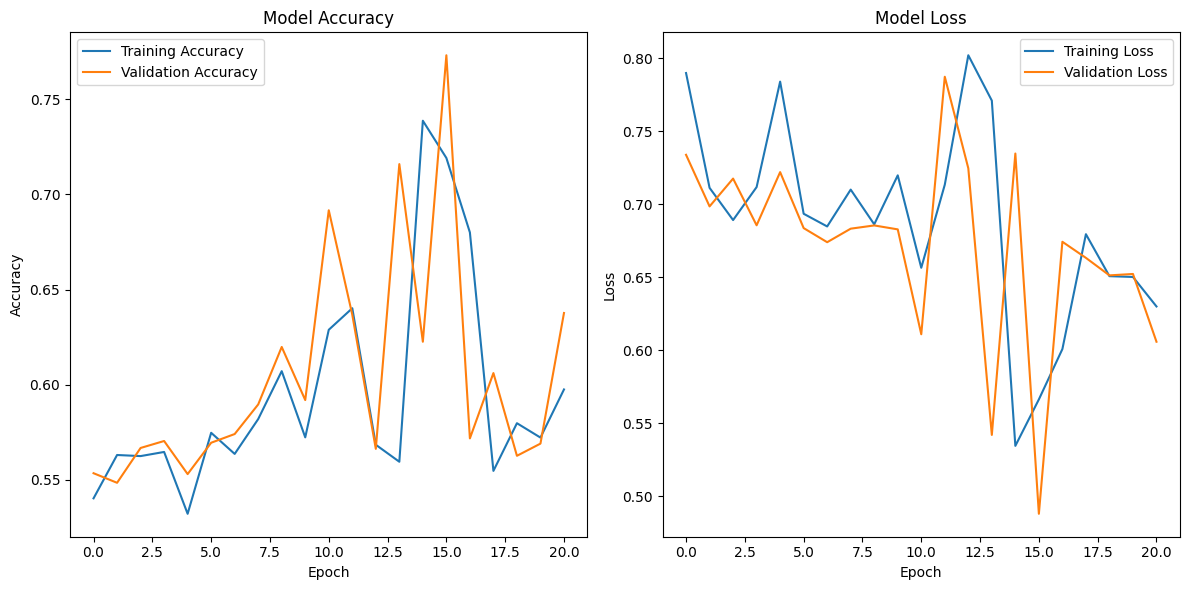

In [59]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [72]:
model = load_model('fda_best_model_1_layerLSTM.keras')
loss, accuracy, f1 = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Avg F1-Score: {f1.numpy().mean()*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7761 - f1_score: 0.7779 - loss: 0.4841
Test Accuracy: 77.09%
Test Avg F1-Score: 77.19%
Errors = 625


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       256
           1       0.98      0.51      0.67      1240
           2       0.71      0.99      0.83      1232

    accuracy                           0.77      2728
   macro avg       0.79      0.83      0.77      2728
weighted avg       0.83      0.77      0.75      2728



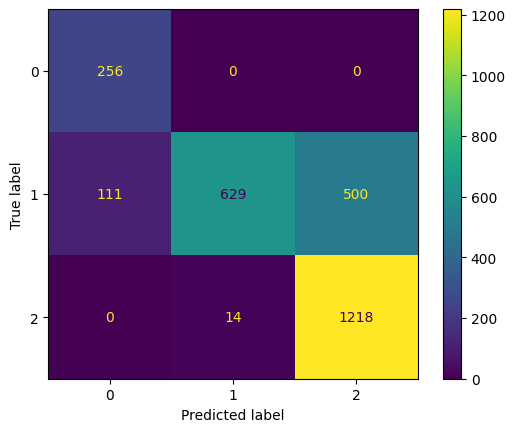

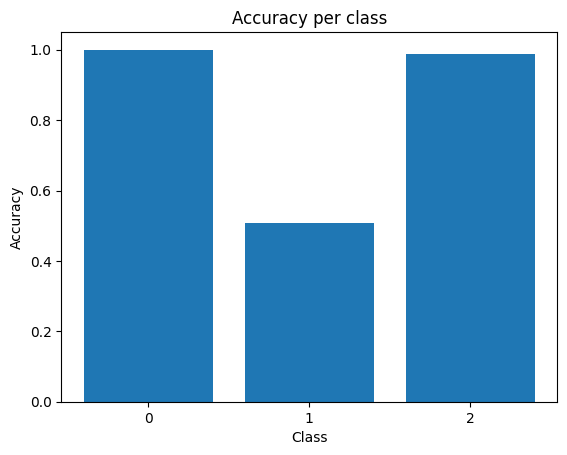

In [73]:
# plot classification report
y_pred = model.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
y_test_true = np.argmax(y_test, axis=1)
print(classification_report(y_test_true, y_pred))

# plot confusion matrix
cm = confusion_matrix(y_test_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1','2'])
disp.plot()

# plot accuracy per class
plt.figure()
class_accuracy = cm.diagonal()/cm.sum(axis=1)
plt.bar(['0','1','2'],class_accuracy)
plt.title('Accuracy per class')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.show()

## 1.3 Other LSTM architechture - 2 layers LSTM instead of just one

In [79]:
def build_model(input_shape,num_classes,lstm_units=50,dense_units=100,dropout=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(dense_units,activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    return model

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('fda_best_model2layers.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [80]:
### ---------- CROSS-VALIDATION ------------ ###

# model_lstm2 = KerasClassifier(build_fn=build_model,input_shape=(timeframes,features),epochs=100,optimizer='adam',verbose=1,callbacks=[early_stop])

# param_grid = {
#     'model__lstm_units': [50,100,200],
#     'model__dense_units': [50,100,200],
#     'model__dropout': [0.5,0.2],
#     'batch_size': [16,32]
# }

# grid_lstm2 = GridSearchCV(estimator=model_lstm2,param_grid=param_grid,n_jobs=-1,cv=2, verbose=5)

# grid_lstm2_result = grid_lstm2.fit(X_train_norm, y_train)
# [grid_lstm1_result.best_score_, grid_lstm1_result.best_params_]

In [82]:
batch_size = 64 #grid_lstm1_result.best_params_['batch_size']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
dense_units = 100 #grid_lstm1_result.best_params_['model__dense_units']
lstm_units = 100 #grid_lstm1_result.best_params_['model__lstm_units']

model = build_model((X_train_norm.shape[1], X_train_norm.shape[-1]),3,lstm_units,dense_units,dropout)
history = model.fit(X_train_norm, y_train, epochs=30, batch_size=batch_size, validation_split=0.2,callbacks=[checkpoint,early_stop])

/home/infres/acosta-23/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4769 - f1_score: 0.4177 - loss: 0.8830
Epoch 1: val_loss improved from inf to 0.82839, saving model to fda_best_model2layers.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 48s 330ms/step - accuracy: 0.4772 - f1_score: 0.4181 - loss: 0.8826 - val_accuracy: 0.5131 - val_f1_score: 0.4510 - val_loss: 0.8284
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5395 - f1_score: 0.5470 - loss: 0.7661
Epoch 2: val_loss did not improve from 0.82839
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 338ms/step - accuracy: 0.5395 - f1_score: 0.5469 - loss: 0.7661 - val_accuracy: 0.4750 - val_f1_score: 0.3500 - val_loss: 0.8856
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5019 - f1_score: 0.4958 - loss: 0.8717
Epoch 3: val_loss improved from 0.82839 to 0.81835, saving model to fda_best_model2layers.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 44s 323ms/step - accuracy: 0.5018 - f1_score: 0.4958 - loss: 0.8717 - val_accuracy: 0.4874 

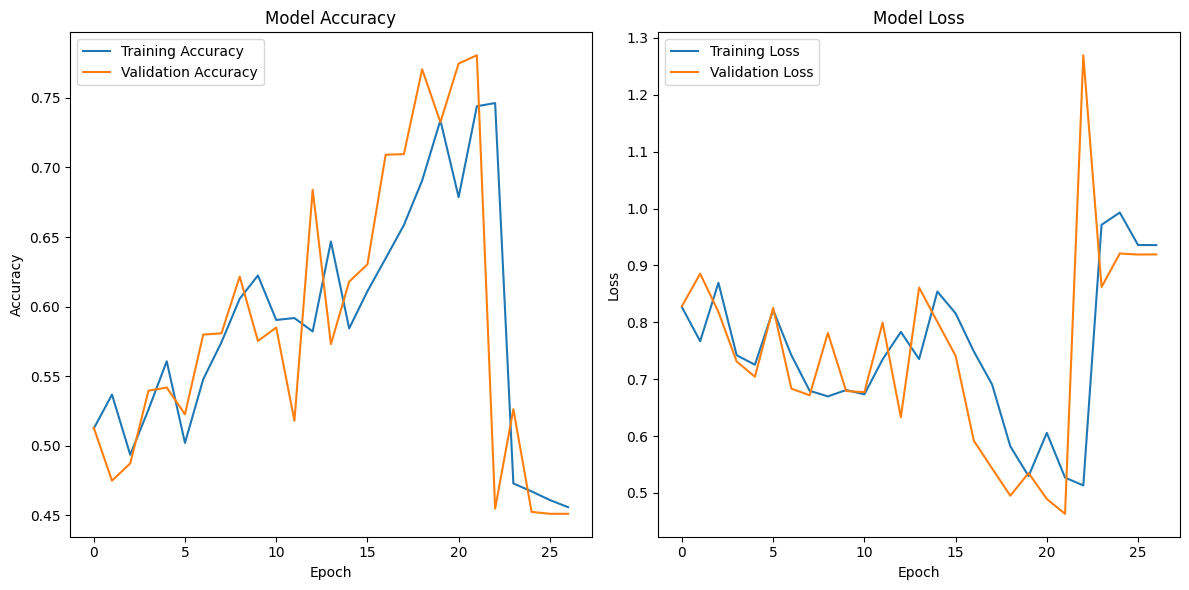

In [83]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()


In [84]:
model = load_model('fda_best_model2layers.keras')
loss, accuracy,f1 = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Avg F1-Score: {f1.numpy().mean()*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7939 - f1_score: 0.8196 - loss: 0.4521
Test Accuracy: 79.33%
Test Avg F1-Score: 81.65%
Errors = 564


86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       256
           1       0.99      0.55      0.71      1240
           2       0.70      1.00      0.83      1232

    accuracy                           0.79      2728
   macro avg       0.85      0.84      0.82      2728
weighted avg       0.85      0.79      0.78      2728



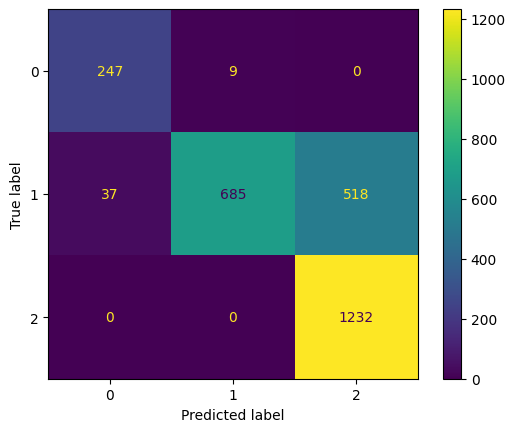

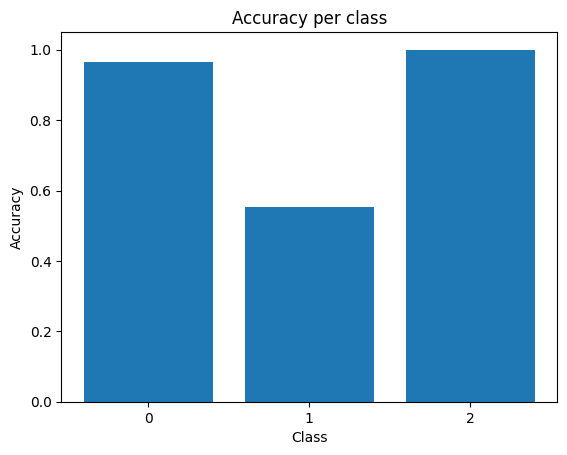

In [85]:
# plot classification report
y_pred = model.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
y_test_true = np.argmax(y_test, axis=1)
print(classification_report(y_test_true, y_pred))

# plot confusion matrix
cm = confusion_matrix(y_test_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1','2'])
disp.plot()

# plot accuracy per class
plt.figure()
class_accuracy = cm.diagonal()/cm.sum(axis=1)
plt.bar(['0','1','2'],class_accuracy)
plt.title('Accuracy per class')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.show()

## 1.4 Pytorch LSTM (same 2 layers architechture)

In [233]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, num_classes ,hidden_dim, dense_units ,dropout=0.2):
        super(LSTMClassifier, self).__init__()

        # First LSTM layer with dropout
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True,)
        self.dropout1 = nn.Dropout(dropout)

        # Second LSTM layer with dropout
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        # Final dense layer for binary classification
        self.dense = nn.Linear(hidden_dim, dense_units)

        self.linear = nn.Linear(dense_units, num_classes)

    def forward(self, x):
        # Passing data through the first LSTM layer
        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        # Passing data through the second LSTM layer
        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        # Only take the output from the last time step
        x = x[:, -1, :]

        # Passing through the dense layers
        x = self.dense(x)
        x = torch.relu(x)

        x = self.linear(x)

        return x


In [234]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [235]:
X_train_torch, X_val, y_train_torch, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# normalizing data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_torch.reshape(X_train_torch.shape[0],X_train_torch.shape[-1]))
X_val_norm = scaler.transform(X_val.reshape(X_val.shape[0],X_val.shape[-1]))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_norm = X_train_norm.reshape(X_train_torch.shape[0],X_train_torch.shape[-1],1)
X_val_norm = X_val_norm.reshape(X_val.shape[0],X_val.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
print(X_train_norm.shape,X_val_norm.shape ,X_test_norm.shape, y_train_torch.shape,y_val.shape)

# loading dataloader
train_dataset = TimeSeriesDataset(X_train_norm, y_train)
val_dataset = TimeSeriesDataset(X_val_norm, y_val)
test_dataset = TimeSeriesDataset(X_test_norm, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

(8729, 5120, 1) (2183, 5120, 1) (2728, 5120, 1) (8729, 3) (2183, 3)


In [238]:
from tqdm import tqdm

def save_checkpoint(model, filename="fda_best_model_pytorch.pth"):
    torch.save(model.state_dict(), filename)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100,early_stop=10):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_accuracy = 0, 0
        for (i,(X_batch, y_batch)) in enumerate(tqdm(train_loader)):
            # print(X_batch.shape, y_batch.shape)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() 
            predictions = torch.from_numpy(to_categorical(torch.argmax(torch.softmax(outputs,dim=1),dim=1)))
            total_train_accuracy += (predictions == y_batch).all(dim=1).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader.dataset)

        # Validation
    # if epoch%5 == 0:
        model.eval()
        total_val_loss, total_val_accuracy = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
                predictions = torch.from_numpy(to_categorical(torch.argmax(torch.softmax(outputs,dim=1),dim=1)))
                total_val_accuracy += (predictions == y_batch).all(dim=1).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader.dataset)

        print(f'Epoch {epoch + 1}/{epochs}, '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, '
            f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            save_checkpoint(model, "fda_best_model_pytorch.pth")
        else:
            epochs_no_improve+=1
            if epochs_no_improve >= early_stop:
                print(f"Early stop triggered at epoch {epoch} !!!")
                break
            
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)
            
    return history

In [ ]:
torch.manual_seed(43)
input_dim = X_train_norm.shape[1]
hidden_dim = 100
model = LSTMClassifier(input_dim,3,hidden_dim,100)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = train_model(model, criterion, optimizer, train_loader,val_loader ,epochs=50)

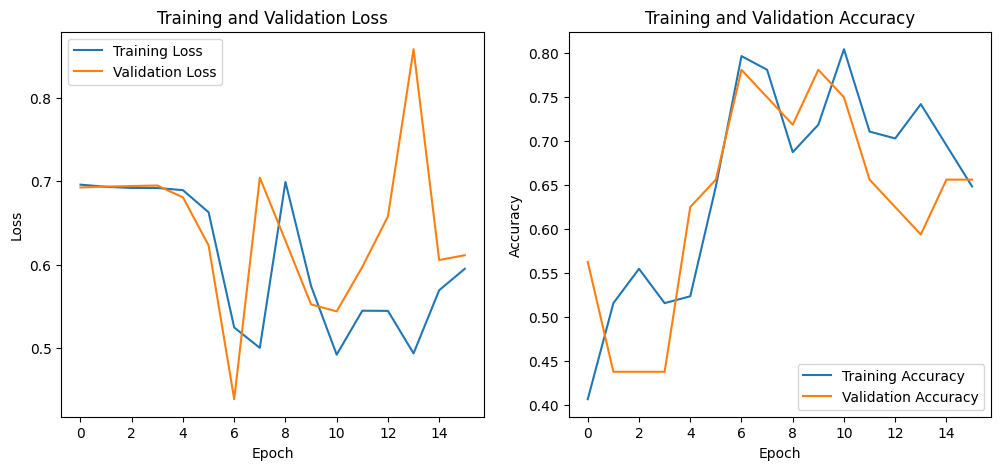

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model.load_state_dict(torch.load('fda_best_model_pytorch.pth'))
def evaluate_model(model, test_loader):
    model.eval()
    total_loss, total_accuracy = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            predictions = torch.from_numpy(to_categorical(torch.argmax(torch.softmax(outputs,dim=1),dim=1)))
            total_accuracy += (predictions == y_batch).all(dim=1).sum().item()
    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)
    return avg_loss, avg_accuracy

# Assuming test_loader is a DataLoader object for your test data
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
print(f'Errors = {int(len(y_test) - len(y_test)*test_accuracy)}')

Test Loss: 0.4014742225408554, Test Accuracy: 0.825
Errors = 7


## 1.5 Applying SMOTE

In [244]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 KB 4.7 MB/s eta 0:00:00a 0:00:01


In [257]:
X_train_reduced,X_test,y_train_reduced,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X_train_reduced, y_train_reduced = make_dataset_imbalanced(X_train, y_train, class_to_reduce=1, reduction_factor=0.1)
# X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
# X_train_reduced.shape, y_train_reduced.shape

from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced.reshape(X_train_reduced.shape[0],X_train_reduced.shape[-1]), y_train_reduced)

X_train_smote_norm = scaler.fit_transform(X_train_smote)
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_smote_norm = X_train_smote_norm.reshape(X_train_smote_norm.shape[0],X_train_smote_norm.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
print(X_train_smote_norm.shape, X_test_norm.shape)
np.unique(np.argmax(y_train_reduced,axis=-1),return_counts=True), np.unique(np.argmax(y_train_smote,axis=-1),return_counts=True)

(14904, 5120, 1) (2728, 5120, 1)


((array([0, 1, 2]), array([ 984, 4960, 4968])),
 (array([0, 1, 2]), array([4968, 4968, 4968])))

In [261]:
def build_model(input_shape,num_classes,lstm_units=50,dense_units=100,dropout=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(dense_units,activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    return model

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('fda_best_model_smote.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

batch_size = 64 #grid_lstm1_result.best_params_['batch_size']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
dense_units = 150 #grid_lstm1_result.best_params_['model__dense_units']
lstm_units = 150 #grid_lstm1_result.best_params_['model__lstm_units']

smote_model = build_model((X_train_norm.shape[1], X_train_norm.shape[-1]),3,lstm_units,dense_units,dropout)
history_smote = smote_model.fit(X_train_norm, y_train, epochs=30, batch_size=batch_size, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4387 - f1_score: 0.3046 - loss: 0.9943
Epoch 1: val_loss improved from inf to 0.92122, saving model to fda_best_model_smote.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 378ms/step - accuracy: 0.4387 - f1_score: 0.3047 - loss: 0.9940 - val_accuracy: 0.4422 - val_f1_score: 0.2308 - val_loss: 0.9212
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4564 - f1_score: 0.2970 - loss: 0.9425
Epoch 2: val_loss improved from 0.92122 to 0.91831, saving model to fda_best_model_smote.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 366ms/step - accuracy: 0.4564 - f1_score: 0.2971 - loss: 0.9425 - val_accuracy: 0.4370 - val_f1_score: 0.2382 - val_loss: 0.9183
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4552 - f1_score: 0.2913 - loss: 0.9455
Epoch 3: val_loss did not improve from 0.91831
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - accuracy: 0.4552 - f1_score: 0.2914 - loss: 0.9455 - val_accuracy: 0.4387 - 

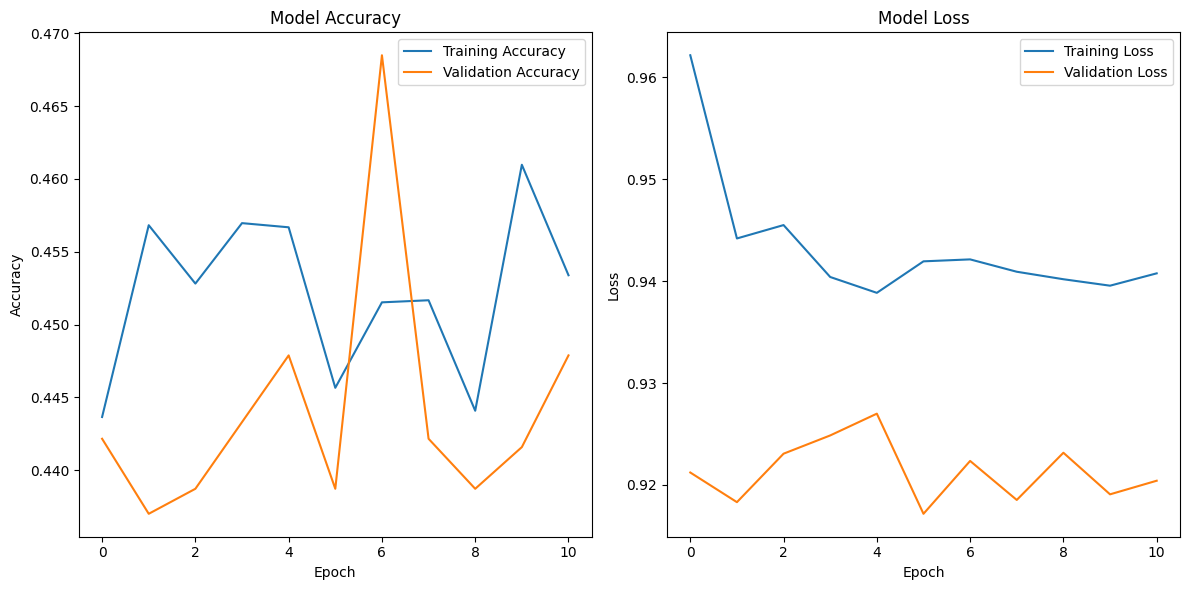

In [262]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_smote.history['accuracy'], label='Training Accuracy')
plt.plot(history_smote.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_smote.history['loss'], label='Training Loss')
plt.plot(history_smote.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [263]:
model_smote = load_model('fda_best_model_smote.keras')
loss, accuracy,f1 = model_smote.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.4653 - f1_score: 0.2172 - loss: 0.9242
Test Accuracy: 45.60%
Errors = 1484


86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       256
           1       0.65      0.01      0.02      1240
           2       0.45      1.00      0.62      1232

    accuracy                           0.46      2728
   macro avg       0.37      0.34      0.22      2728
weighted avg       0.50      0.46      0.29      2728



/home/infres/acosta-23/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/infres/acosta-23/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/infres/acosta-23/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

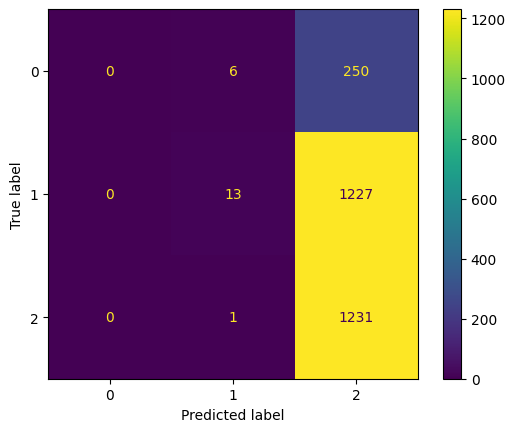

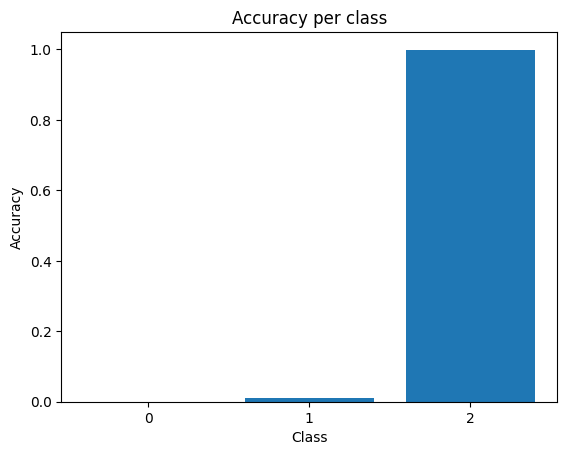

In [264]:
# plot classification report
y_pred = model_smote.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
y_test_true = np.argmax(y_test, axis=1)
print(classification_report(y_test_true, y_pred))

# plot confusion matrix
cm = confusion_matrix(y_test_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1','2'])
disp.plot()

# plot accuracy per class
plt.figure()
class_accuracy = cm.diagonal()/cm.sum(axis=1)
plt.bar(['0','1','2'],class_accuracy)
plt.title('Accuracy per class')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.show()